In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

def evaluation_metrics(y_pred, y_label, thresh=0.5):
    true_pos = []
    true_neg = []
    false_pos = []
    false_neg = []

    for i in range(len(y_pred)):
        if y_label[i] < thresh and y_pred[i] < thresh:
            true_neg.append(i)
        elif y_label[i] > thresh and y_pred[i] > thresh:
            true_pos.append(i)
        elif y_label[i] < thresh and y_pred[i] > thresh:
            false_pos.append(i)
        elif y_label[i] > thresh and y_pred[i] < thresh:
            false_neg.append(i)

    TP = len(true_pos)
    TN = len(true_neg)
    FP = len(false_pos)
    FN = len(false_neg)

    fpr, tpr, thresholds = roc_curve(y_label, y_pred, pos_label=1)

    eval = \
    {
        'accuracy'  : (TP + TN) / (TP + TN + TN + FN) if (TP + TN + TN + FN) > 0 else 0, 
        'precision' : TP / (TP + FP) if (TP + FP) > 0 else 0,
        'recall'    : TP / (TP + FN) if (TP + FN) > 0 else 0,
        'f1'        : (2*TP) / (2*TP + FP + FN) if (TP + FP + FN) > 0 else 0,
        'roc_auc'   : auc(fpr, tpr),
        'fpr'       : fpr,
        'tpr'       : tpr
    }

    return eval

In [2]:
# *** LOAD DATA *** 
from sklearn.model_selection import train_test_split

nominal_sample = pd.read_csv('2015_sample.csv')
failure_sample = pd.read_csv('2015_failures.csv')

# For further testing on data from the future
#future_nominal = pd.read_csv('2018_q1_sample.csv')
#future_failure = pd.read_csv('2018_q1_failures.csv')

nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)

feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

data_curr = pd.concat([nominal_sample, failure_sample])

In [3]:
y_curr = data_curr['failure']
x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=0.8, random_state=1)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
x_train.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_12_normalized,smart_12_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
680,2015-01-21,Z302624B,ST4000DM000,4.000787e+12,0,114.0,78740800.0,98.0,0.0,100.0,...,100.0,2.0,18.0,18.0,100.0,0.0,100.0,0.0,200.0,0.0
200,5/21/15,Z300KGTL,ST4000DM000,4.000790e+12,1,116.0,114062824.0,91.0,0.0,100.0,...,100.0,8.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0
56,2015-03-03,5XW033AT,ST31500541AS,1.500302e+12,0,120.0,243190558.0,100.0,0.0,100.0,...,100.0,65.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0
208,2015-10-10,MJ1311YNG3EVWA,Hitachi HDS5C3030ALA630,3.000593e+12,0,100.0,0.0,123.0,567.0,100.0,...,100.0,15.0,230.0,26.0,100.0,0.0,100.0,0.0,200.0,19.0
963,4/9/15,Z300ZR02,ST4000DM000,4.000790e+12,1,115.0,242487744.0,92.0,0.0,100.0,...,100.0,8.0,30.0,30.0,100.0,0.0,100.0,0.0,200.0,0.0


In [5]:
train_norm = pd.DataFrame()
test_norm = pd.DataFrame()
manufacturers = ['ST','Hi','WD','To','HG']
for man in manufacturers:
    data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
    test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
    max_ = data_sub.max()
    del max_['date']
    min_ = data_sub.min()
    del min_['date']
    for col in feature_columns:
        range_ = max_[col] - min_[col]
        if range_==0:
            range_ = 1
        data_sub[col] = (data_sub[col] - min_[col])/range_
        test_sub[col] = (test_sub[col] - min_[col])/range_
    train_norm = pd.concat([train_norm,data_sub])
    test_norm = pd.concat([test_norm,test_sub])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:

#data_future = pd.concat([future_nominal, future_failure])
#y_future = data_future['failure']
#x_future = data_future[feature_columns]

x_train = train_norm.sample(frac=1)[feature_columns]
x_val = test_norm.sample(frac=1)[feature_columns]

x_train = x_train.values
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values
#x_future = x_future.values
#y_future = y_future.values

# *** LOAD DATA ***

In [7]:
# *** MODELS ***
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier()
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)



models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_rbf, svm_poly, svm_sig, rfc, rfc100, boost1, boost2, gnb, ada]
# *** MODELS ***

In [8]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, rfc, rfc100, boost1, boost2, gnb, ada]
models = [lr1, svm_linear, rfc, rfc100, boost1, boost2, gnb, ada]

In [17]:
models = [svm_poly]

In [18]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v = evaluation_metrics(pred_val, y_val)
    eval_t = evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    
# *** RUN MODELS ***

In [19]:
import winsound

In [20]:
winsound.MessageBeep()

In [21]:
models_plot = [lr1, rfc, svm_poly, boost2, gnb, ada]

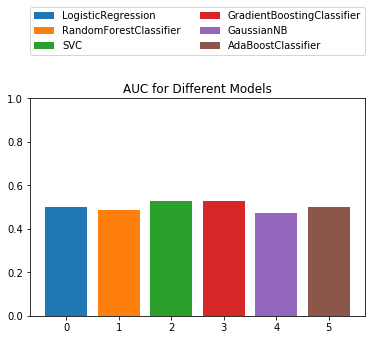

In [22]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models")
plt.ylim([0,1])
plt.show()

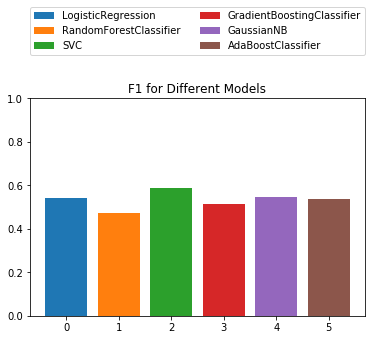

In [23]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

In [24]:
model_results[gnb]

{'train': {'accuracy': 0.6122661122661123,
  'f1': 0.5879284649776453,
  'fpr': array([0.00000000e+00, 0.00000000e+00, 8.78734622e-04, ...,
         9.97363796e-01, 9.97363796e-01, 1.00000000e+00]),
  'precision': 0.5130039011703511,
  'recall': 0.6884816753926701,
  'roc_auc': 0.5209243889497205,
  'tpr': array([0.00000000e+00, 8.72600349e-04, 8.72600349e-04, ...,
         9.99127400e-01, 1.00000000e+00, 1.00000000e+00])},
 'val': {'accuracy': 0.6022988505747127,
  'f1': 0.5441176470588235,
  'fpr': array([0.        , 0.00343643, 0.00343643, 0.0137457 , 0.01718213,
         0.01718213, 0.02061856, 0.02749141, 0.04467354, 0.04467354,
         0.05154639, 0.06185567, 0.06185567, 0.0652921 , 0.0790378 ,
         0.08247423, 0.08247423, 0.08934708, 0.09621993, 0.11340206,
         0.11340206, 0.11683849, 0.11683849, 0.12371134, 0.12371134,
         0.12714777, 0.12714777, 0.1443299 , 0.1443299 , 0.14776632,
         0.15463918, 0.1580756 , 0.16151203, 0.16151203, 0.17182131,
         0.17

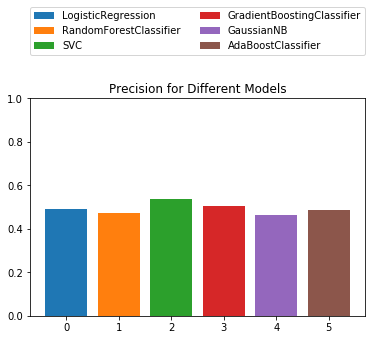

In [25]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Precision for Different Models")
plt.ylim([0,1])
plt.show()

In [28]:
y_train.mean()

0.5017513134851138

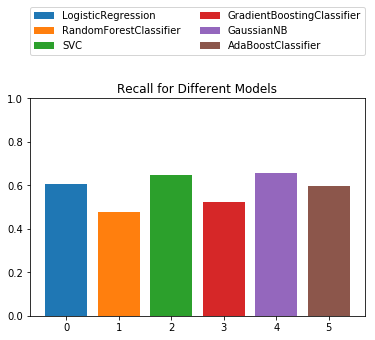

In [26]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Recall for Different Models")
plt.ylim([0,1])
plt.show()

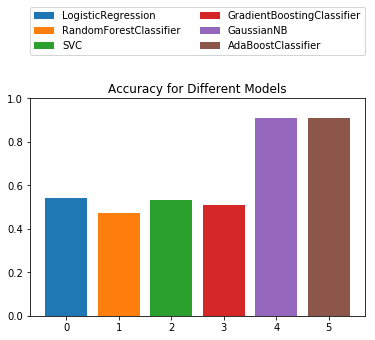

In [55]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

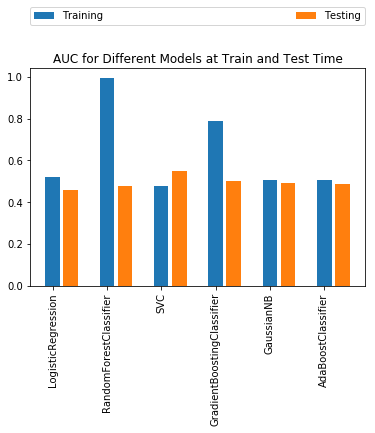

In [56]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.show()

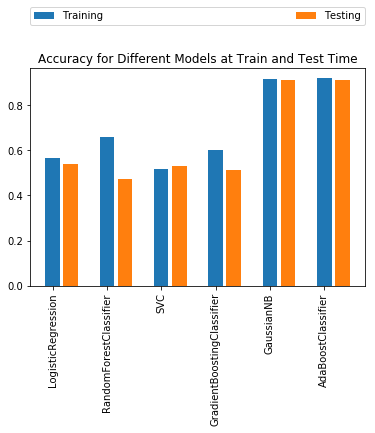

In [58]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.show()

In [115]:
data_curr.model.unique()

array(['HGST HUH728080ALE600', 'Hitachi HDS5C3030ALA630',
       'Hitachi HDS722020ALA330', 'ST4000DM000', 'TOSHIBA DT01ACA300',
       'ST31500541AS', 'ST6000DX000', 'Hitachi HDS5C4040ALE630',
       'HGST HMS5C4040ALE640', 'ST500LM012 HN', 'ST3000DM001',
       'Hitachi HDS723030ALA640', 'HGST HMS5C4040BLE640', 'WDC WD30EFRX',
       'HGST HDS5C4040ALE630', 'ST31500341AS', 'ST9250315AS',
       'WDC WD800AAJB', 'WDC WD10EACS', 'TOSHIBA MD04ABA400V',
       'ST4000DX000', 'ST250LM004 HN', 'WDC WD10EADS', 'WDC WD1600AAJS',
       'ST9320325AS', 'WDC WD60EFRX', 'WDC WD5000LPVX', 'ST3160316AS',
       'WDC WD40EFRX', 'ST33000651AS', 'HGST HDS724040ALE640',
       'WDC WD20EFRX', 'ST32000542AS', 'WDC WD5000BPKT', 'WDC WD800JB',
       'WDC WD800LB', 'ST3500320AS', 'WDC WD10EADX', 'WDC WD2500BPVT',
       'WDC WD800BB', 'ST320LT007', 'Hitachi HDS723030BLE640',
       'ST2000VN000', 'WDC WD3200BEKT', 'WDC WD10EARS', 'ST1500DL003',
       'WDC WD3200BEKX', 'ST3160318AS', 'WDC WD3200AAJS', 'S

In [59]:
# *** RUN MODELS ***

for model in models_plot:
    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    print(model)
    print(mean_squared_error(y_train,pred_train))
    print(mean_squared_error(y_val,pred_val))
    
# *** RUN MODELS ***

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
0.2491911779145174
0.251929783190115
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.059953009535016234
0.31116265817793465
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0

In [8]:
# *** SPECIAL MODEL: xgboost ***
from xgboost import XGBClassifier

xgb = XGBClassifier(objective ='reg:linear', 
                             max_depth = 10,
                             silent = 1,
                             learning_rate = 0.05,
                             n_estimators = 1000)

eval_set = [(x_val, y_val)]

#TODO eval set should be sepearte from Test set!!!

xgb.fit(x_train, y_train, early_stopping_rounds=100,eval_metric= 'logloss', eval_set=eval_set)

pred_train = model.predict_proba(x_train)[:,1]
pred_val = model.predict_proba(x_val)[:,1]

# pred_future = svm_linear.predict_proba(x_future)[:,1]
# pred_train

eval = evaluation_metrics(pred_val, y_val)
print("Trained:  ", model)
print("Precision:", eval['precision'])
print("Recall:   ", eval['recall'])
print("Accuracy: ", eval['accuracy'])
print("F1-Score: ", eval['f1'])
print("AuC:      ", eval['roc_auc'])
print("")

# *** SPECIAL MODEL: xgboost ***

OSError: [WinError 126] The specified module could not be found

In [26]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, mean_absolute_error,accuracy_score
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(x_curr, y_curr, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
eval_set = lgb.Dataset(X_val, label=y_val)
param = {'objective':'binary'}
train_data = lgb.Dataset(X_train, label=y_train, params=param)

num_round = 10
bst = lgb.train(params=param, train_set=train_data, num_boost_round=10, valid_sets=[eval_set])
y_pred = bst.predict(X_test)>.5
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy",accuracy)

[1]	valid_0's binary_logloss: 0.671665
[2]	valid_0's binary_logloss: 0.654115
[3]	valid_0's binary_logloss: 0.639752
[4]	valid_0's binary_logloss: 0.628685
[5]	valid_0's binary_logloss: 0.618385
[6]	valid_0's binary_logloss: 0.609147
[7]	valid_0's binary_logloss: 0.600441
[8]	valid_0's binary_logloss: 0.594815
[9]	valid_0's binary_logloss: 0.589284
[10]	valid_0's binary_logloss: 0.585423
Classification Report: 
              precision    recall  f1-score   support

          0       0.69      0.61      0.65       296
          1       0.63      0.71      0.67       276

avg / total       0.66      0.66      0.66       572

Confusion Matrix: 
 [[180 116]
 [ 79 197]]

Accuracy 0.6590909090909091


In [38]:
nominal_sample.groupby('model').date.count()

model
HGST HDS5C4040ALE630         3
HGST HMS5C4040ALE640       207
HGST HMS5C4040BLE640        98
HGST HUH728080ALE600         2
Hitachi HDS5C3030ALA630    131
Hitachi HDS5C4040ALE630     82
Hitachi HDS722020ALA330    130
Hitachi HDS723030ALA640     38
ST2000VN000                  1
ST250LM004 HN                3
ST3000DM001                 12
ST31500341AS                 4
ST31500541AS                36
ST3160316AS                  2
ST3160318AS                  1
ST33000651AS                 6
ST4000DM000                554
ST4000DX000                  2
ST500LM012 HN                7
ST6000DX000                 34
ST9250315AS                  4
TOSHIBA DT01ACA300           1
TOSHIBA MD04ABA400V          3
WDC WD10EADS                 5
WDC WD10EADX                 1
WDC WD20EFRX                 3
WDC WD30EFRX                33
WDC WD3200AAJS               1
WDC WD40EFRX                 1
WDC WD5000LPVX              12
WDC WD60EFRX                11
WDC WD800AAJB                1
Na